In [6]:
import sys
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
import tensorflow.keras as keras


In [7]:
# Plot settings is a custom module which sets the plot style
sys.path.append(os.path.abspath("../src/visualization"))
from plot_settings import set_plot_style

set_plot_style()


## 1. Read 

In [8]:
X_train, y_train, X_val, y_val, X_test = pd.read_pickle("../data/processed/data.pkl")
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape


((37800, 28, 28, 1),
 (37800, 10),
 (4200, 28, 28, 1),
 (4200, 10),
 (28000, 28, 28, 1))

#####  our model was included custom function(f1_m, precision_m, recall_m). when we want use "load_model" we need to mention that custom_object and import them to this file

In [9]:
sys.path.append(os.path.abspath("../src/models"))
from metrics import f1_m, precision_m, recall_m

model = tf.keras.models.load_model(
    "../models/best_model.h5",
    custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m},
)


## 2. Validation results

In [10]:
# we use argmax to get the index of the max value in each row
y_val_pred = np.argmax(model.predict(X_val), axis=1)
print("y_val_pred", y_val_pred)
y_val_true = np.argmax(y_val, axis=1)
print("y_val_true", y_val_true)


 38/132 [=======>......................] - ETA: 0s

2023-07-06 19:20:46.695633: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


132/132 [==============================] - 0s 3ms/step
y_val_pred [8 1 9 ... 7 7 5]
y_val_true [8 1 9 ... 7 7 5]


#### 2.1 Plot Confusion Matrix

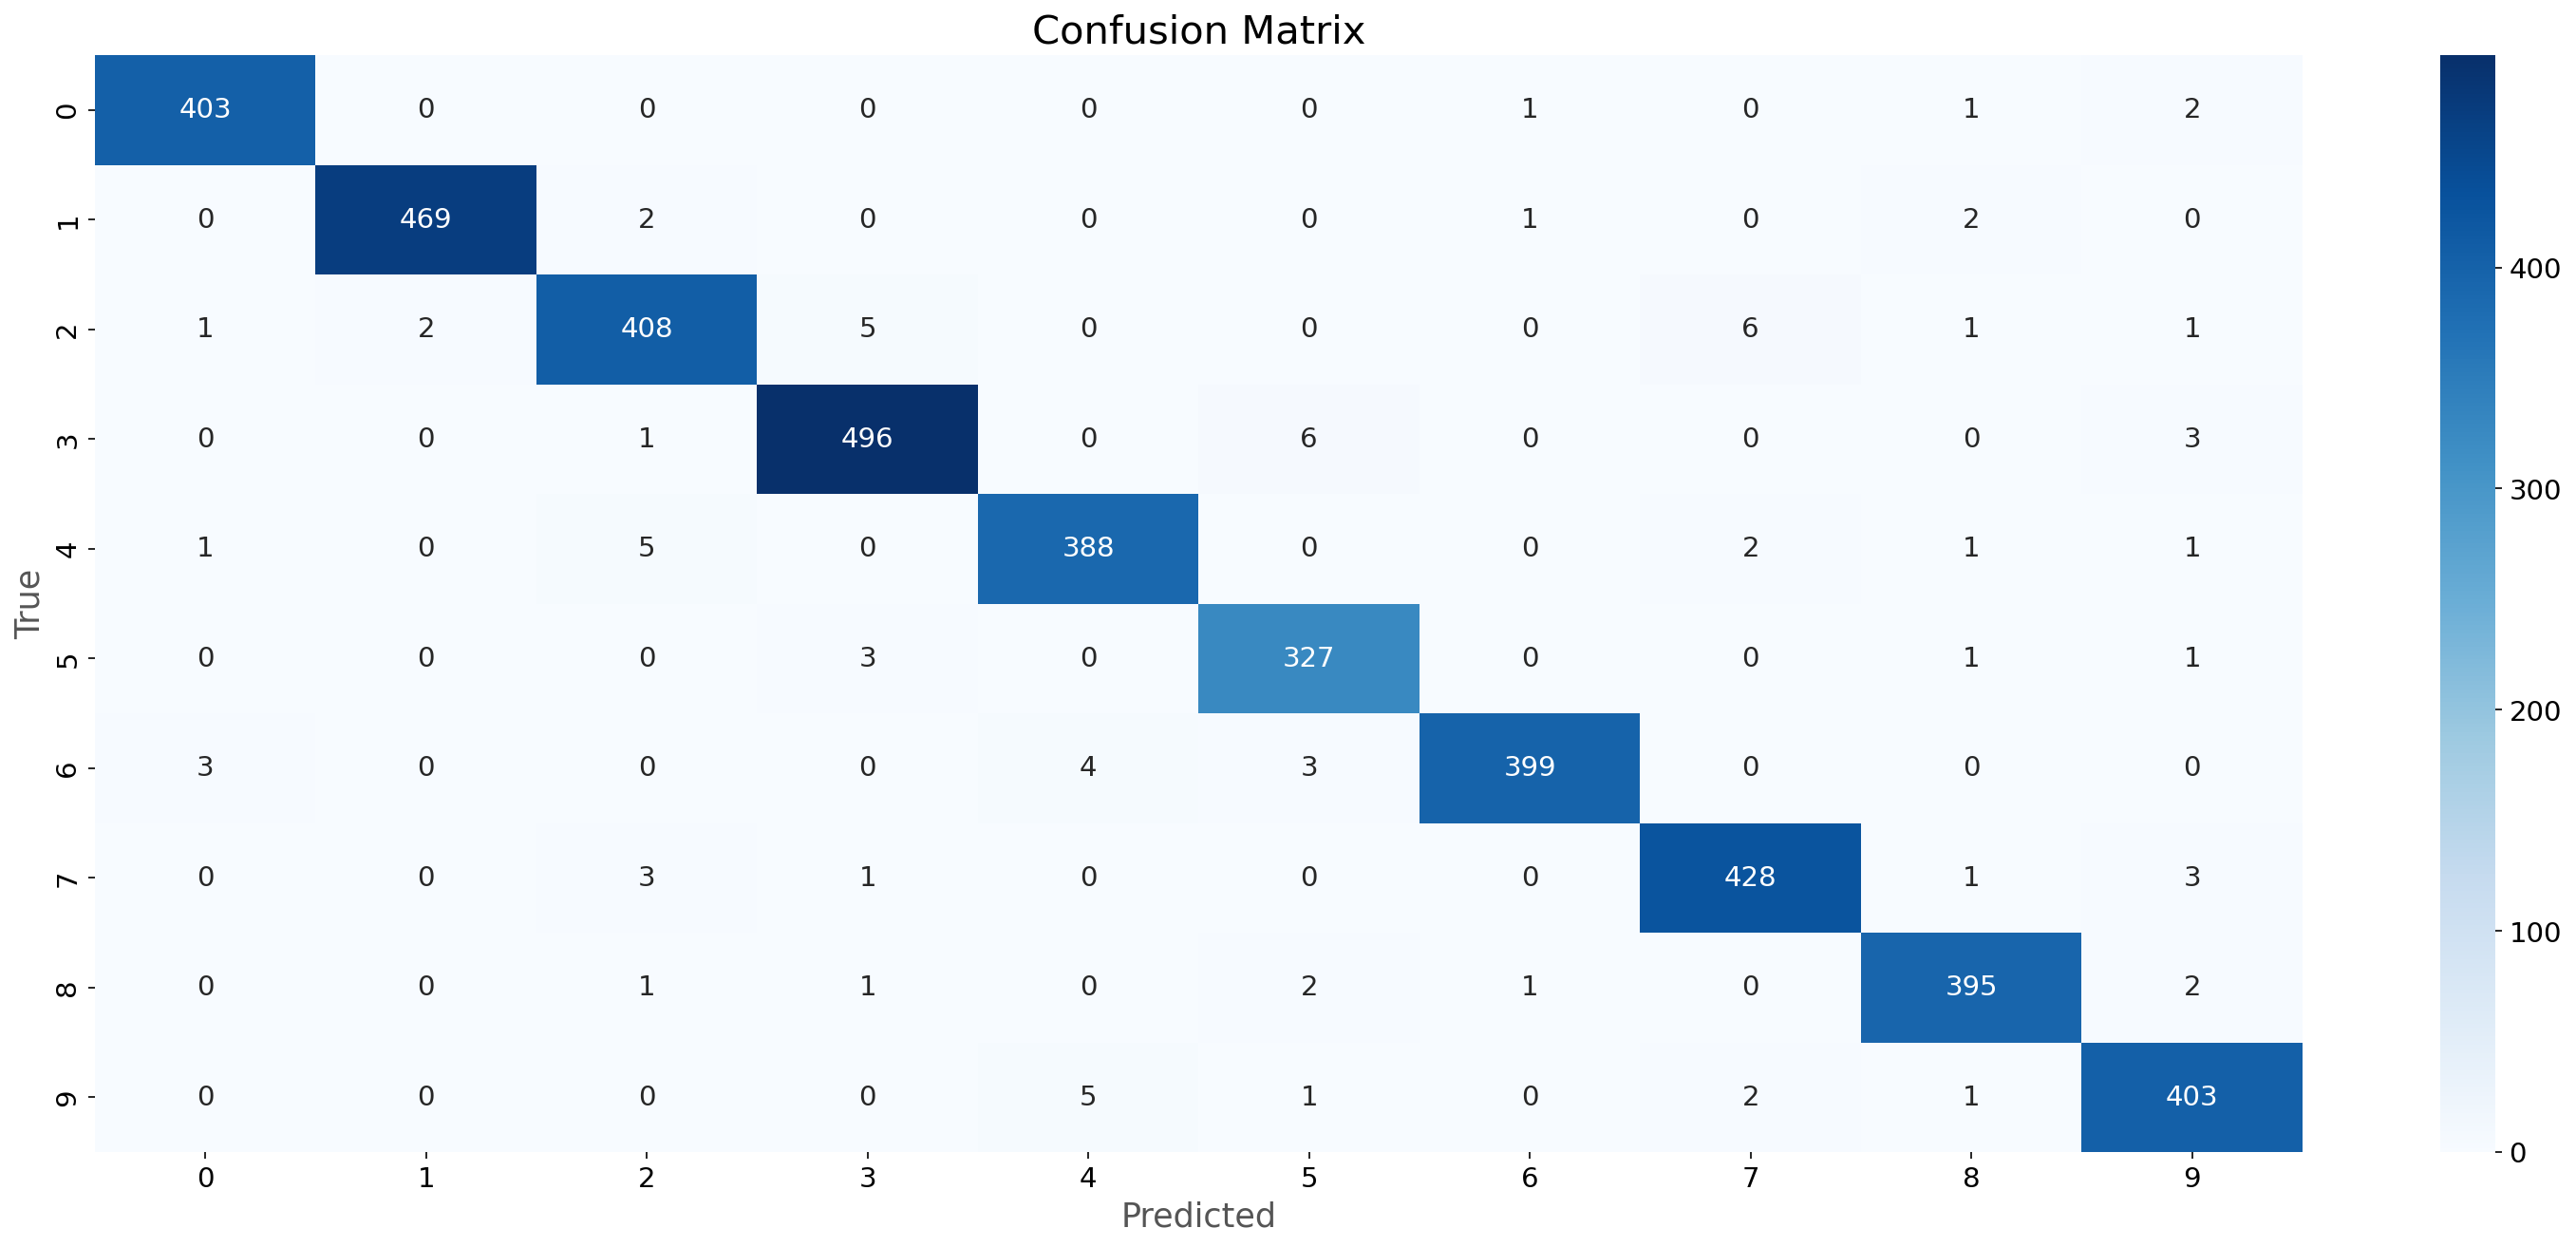

In [11]:
cm = confusion_matrix(y_val_pred, y_val_true)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


#### 2.2 Accuracy

In [12]:
print("Accuracy: ", accuracy_score(y_val_true, y_val_pred))


Accuracy:  0.98


###### It isn't that much bad for our first model. Now we should look at the examples of the model is misclassified

## 3. The Primary Result Visualization


In [13]:
cm_index = cm
np.fill_diagonal(cm_index, 0)
cm_index = np.where(cm_index == cm_index.max())
if len(cm_index) > 1:
    cm_index = [cm_index[0][0], cm_index[1][0]]
cm_index


[2, 7]

##### The class with the most confusions is between class 2 and 7. let's take a look at incorrectly classified examples.

In [14]:
four_incorrect_examples = X_val[
    (y_val_true == cm_index[0]) & (y_val_pred == cm_index[1])
]
four_incorrect_examples = four_incorrect_examples.reshape(-1, 28, 28)
four_incorrect_examples.shape


(3, 28, 28)

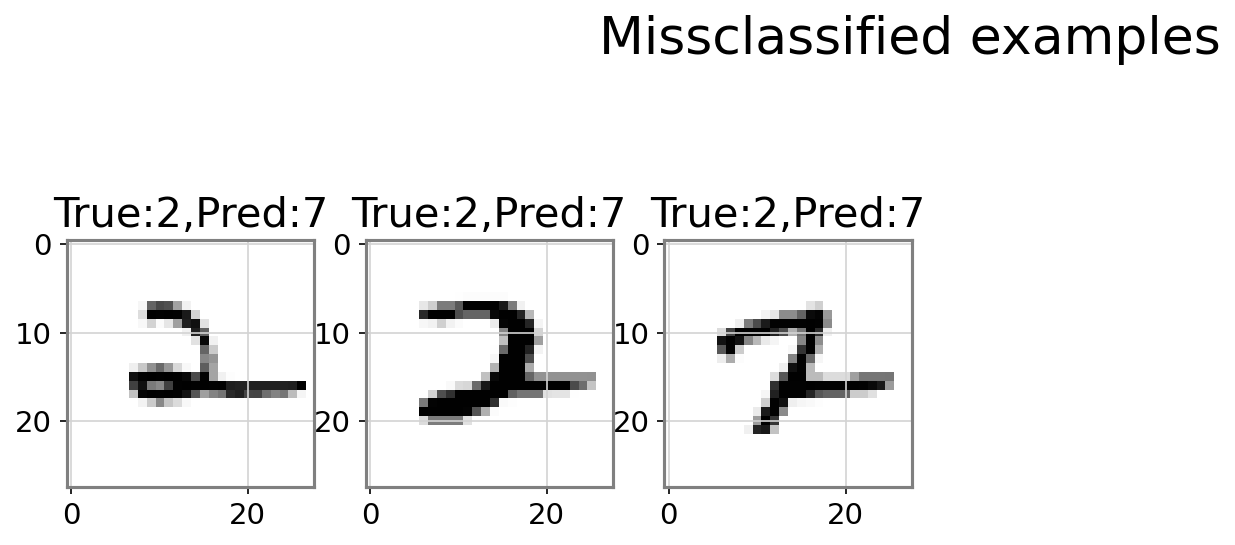

In [15]:
fig = plt.figure(figsize=(15, 15))
fig.suptitle("Missclassified examples")
columns = 6
rows = 6
for i in range(columns * rows + 1):
    if i == four_incorrect_examples.shape[0]:
        break
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(four_incorrect_examples[i], cmap="Greys")
    plt.title("True:{},Pred:{}".format(cm_index[0], cm_index[1]))

plt.show()


##### Looking at the missclassifications, its understandable why the model was unable classify these examples correctly. With the use of data augmentation and hyper-parameter tuning, we should be able to further improve performance.

In [16]:
model.layers


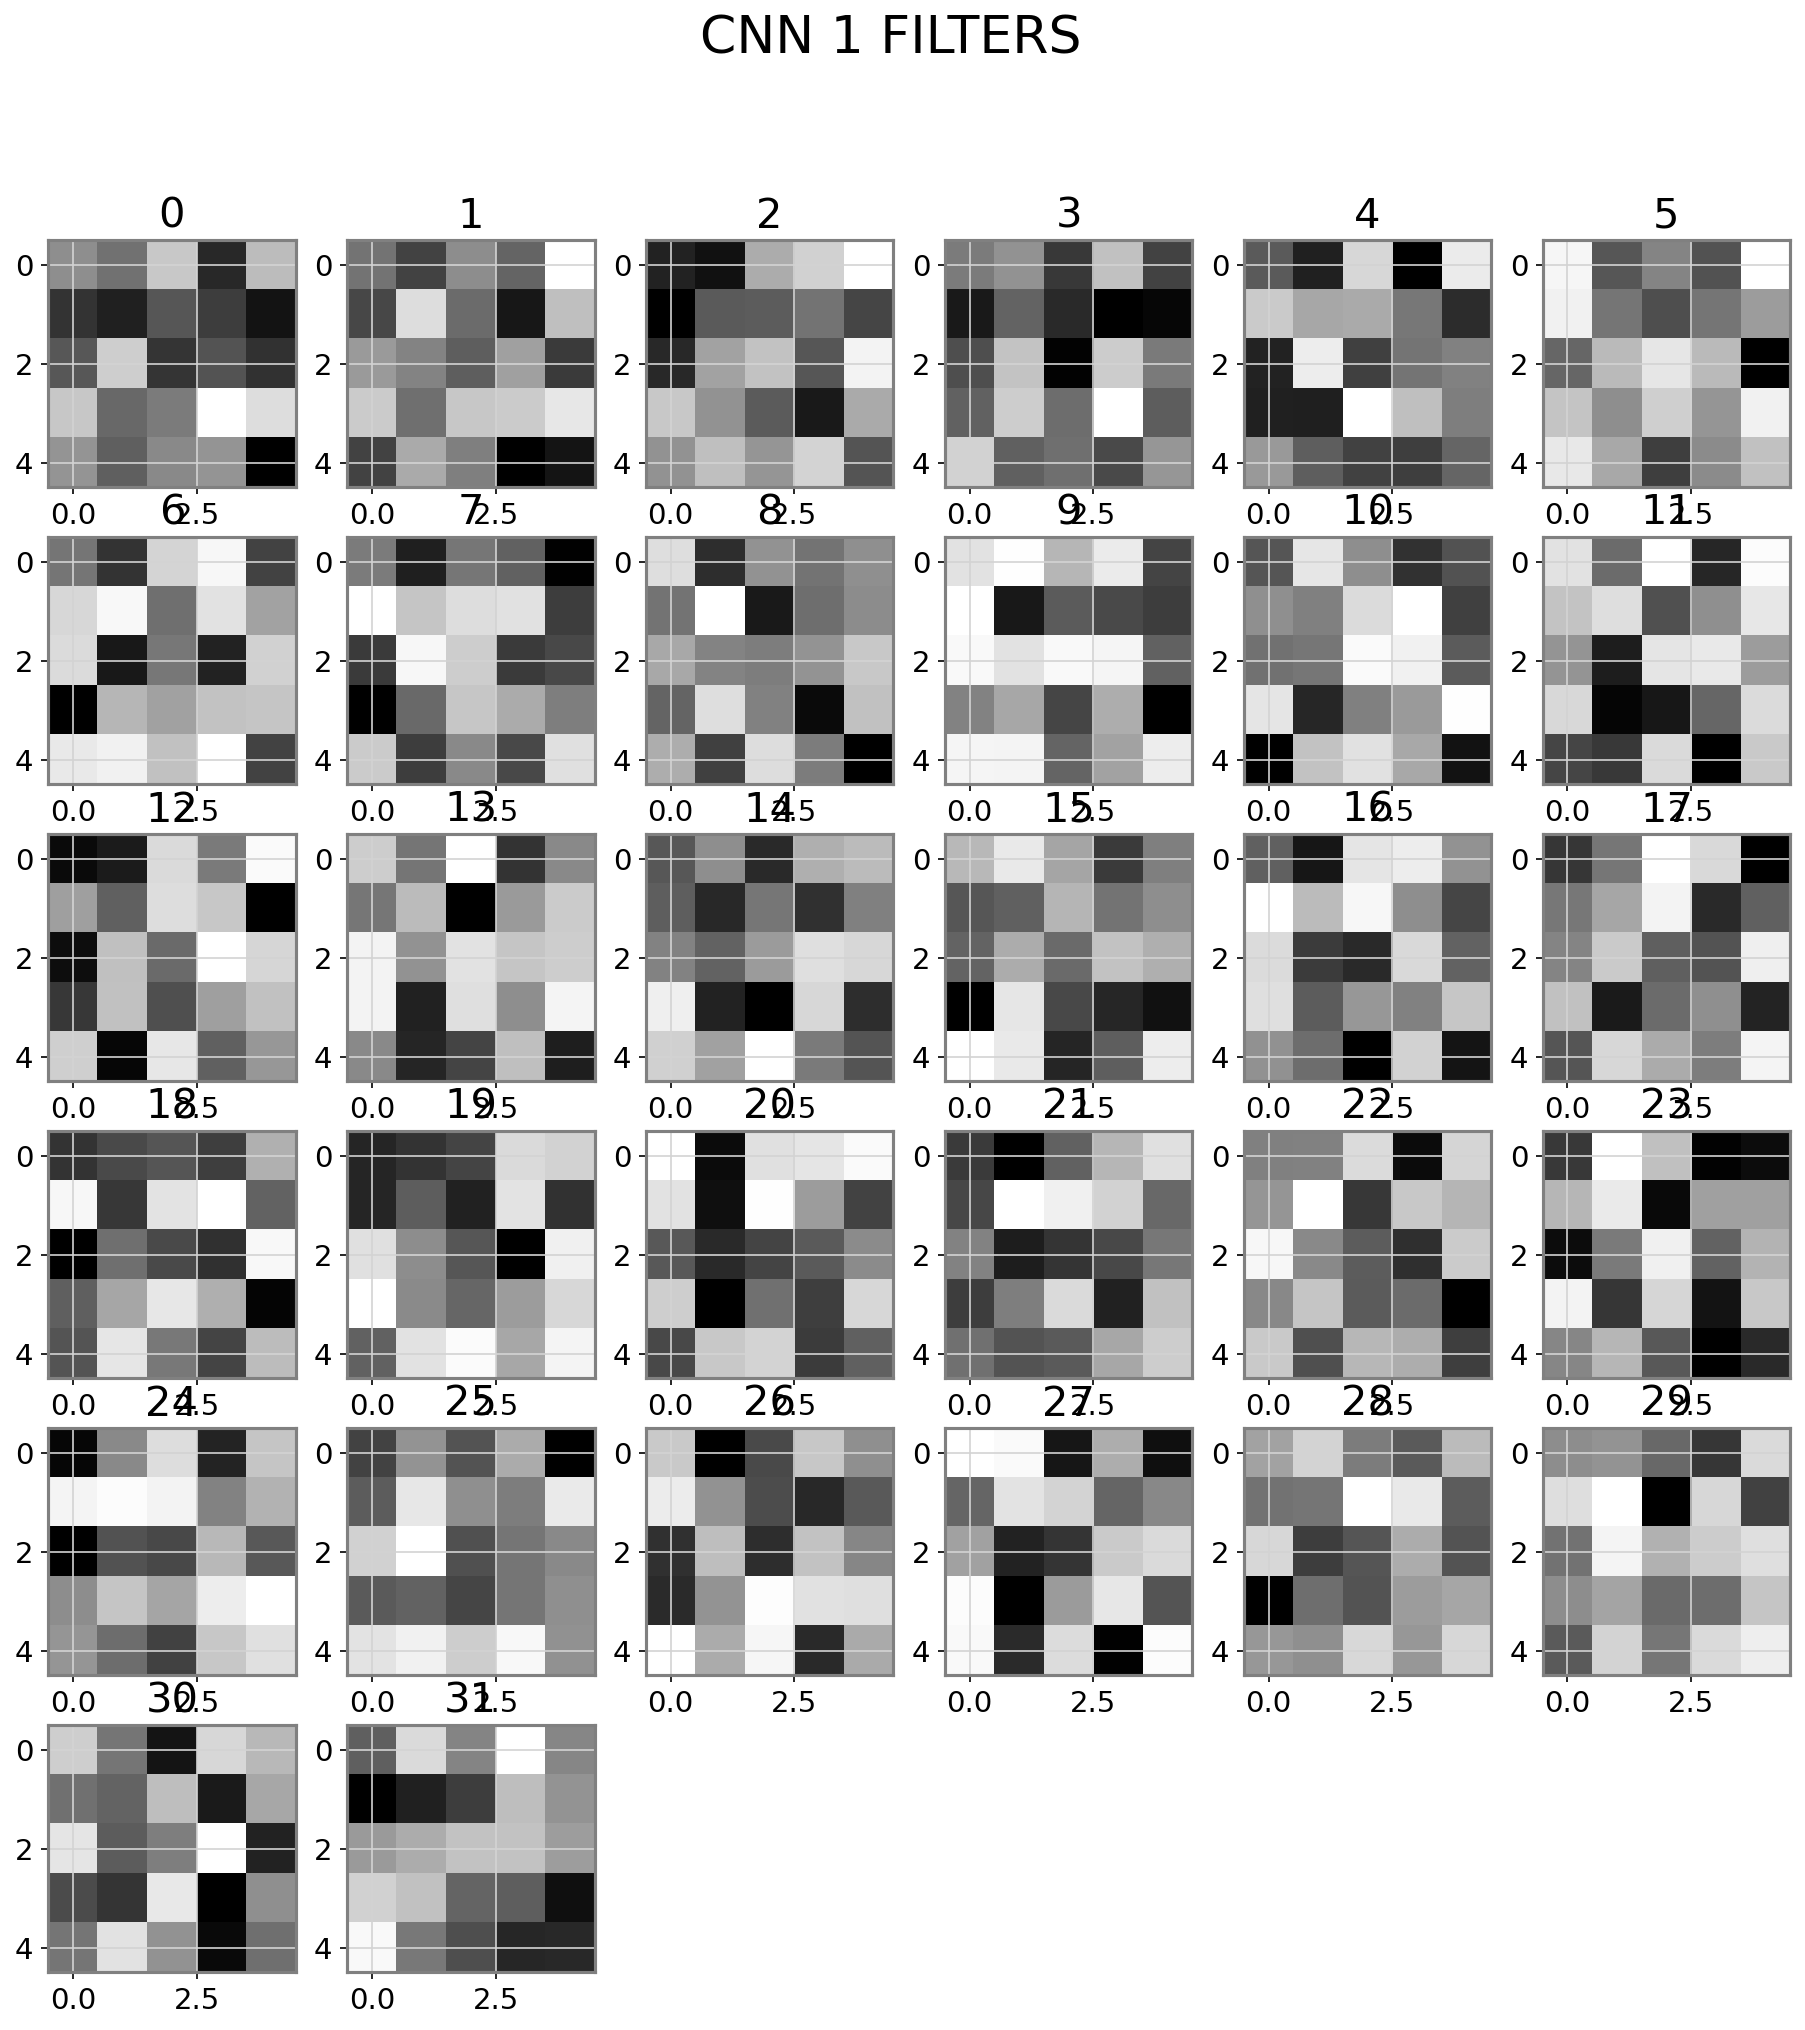

In [17]:
filters_layer_1 = model.layers[1].get_weights()[0]
filters_layer_1 = np.squeeze(filters_layer_1).reshape(32, 5, 5)

fig = plt.figure(figsize=(15, 15))
fig.suptitle("CNN 1 FILTERS")
w = 10
h = 10
columns = 6
rows = 6
for i in range(columns * rows + 1):
    if i == filters_layer_1.shape[0]:
        break
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(filters_layer_1[i], cmap="Greys")
    plt.title(i)

plt.show()


##### Displayed above are the visual representations of the 32 filters learned in the initial convolutional layer. These filters convolve across the images, generating activation maps, often referred to as feature-maps.

##### Feature-maps are designed to capture significant patterns and characteristics from the input, whether that input is an image or feature maps from preceding convolutional blocks.

##### The aim of visualizing these feature maps is to comprehend what aspects of the input are identified and retained within them. Now, let's delve into some of these feature maps to discover what our model is capturing.

In [18]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if "conv" not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)


1 conv2d (None, 24, 24, 32)
5 conv2d_1 (None, 8, 8, 64)


In [19]:
successive_outputs = [layer.output for layer in model.layers[1:]]
fm_model = keras.Model(inputs=model.input, outputs=successive_outputs)

successive_outputs


[<KerasTensor: shape=(None, 24, 24, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 12, 12, 32) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 12, 12, 32) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, 12, 12, 32) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 8, 8, 64) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 4, 4, 64) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 4, 4, 64) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, 4, 4, 64) dtype=float32 (created by layer 'dropout_1')>,
 <KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dropout_2')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (crea

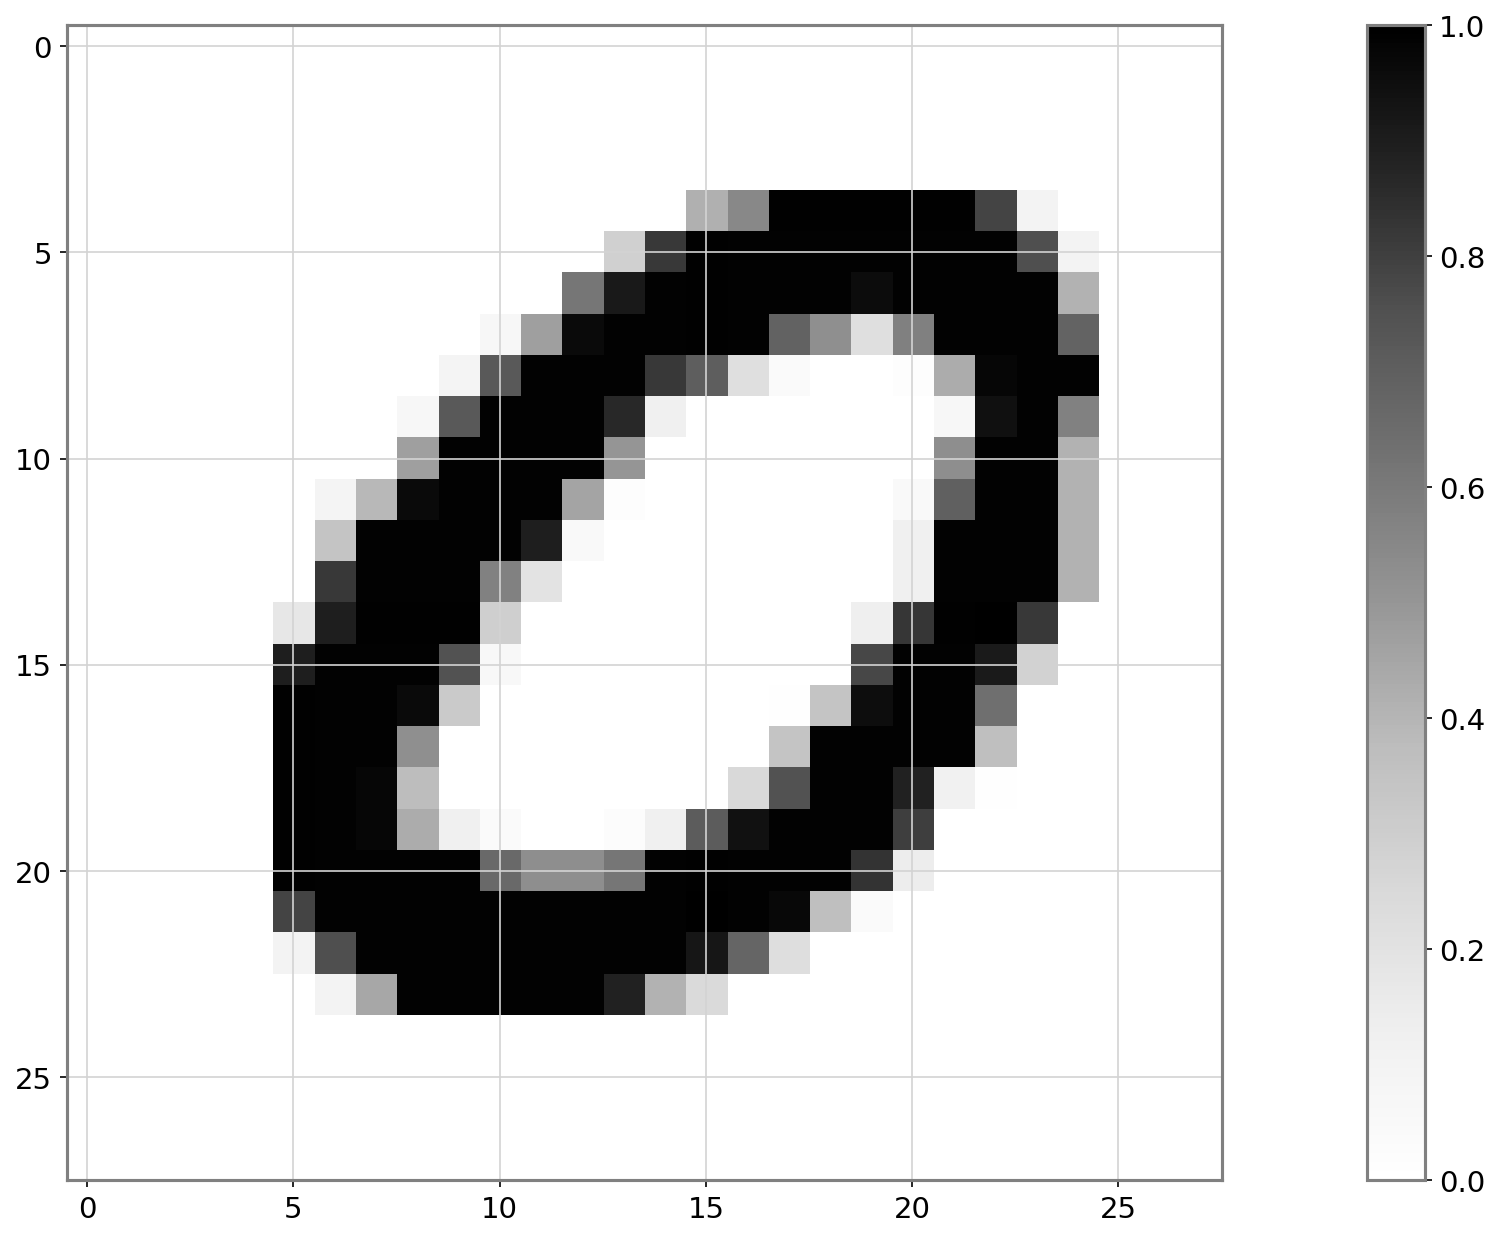

In [20]:
test_example = X_train[[12]]
plt.imshow(test_example[0], cmap="Greys")
plt.colorbar()
plt.show()


In [21]:
successive_feature_maps = fm_model.predict(test_example)
len(successive_feature_maps)  # 12 for 12 layers


1/1 [==============================] - 0s 46ms/step


12

(1, 24, 24, 32)
input_1
(1, 12, 12, 32)
conv2d
(1, 12, 12, 32)
max_pooling2d
(1, 12, 12, 32)
batch_normalization
(1, 8, 8, 64)
dropout
(1, 4, 4, 64)
conv2d_1
(1, 4, 4, 64)
max_pooling2d_1
(1, 4, 4, 64)
batch_normalization_1
(1, 1024)
dropout_1
(1, 128)
flatten
(1, 128)
dense
(1, 10)
dropout_2


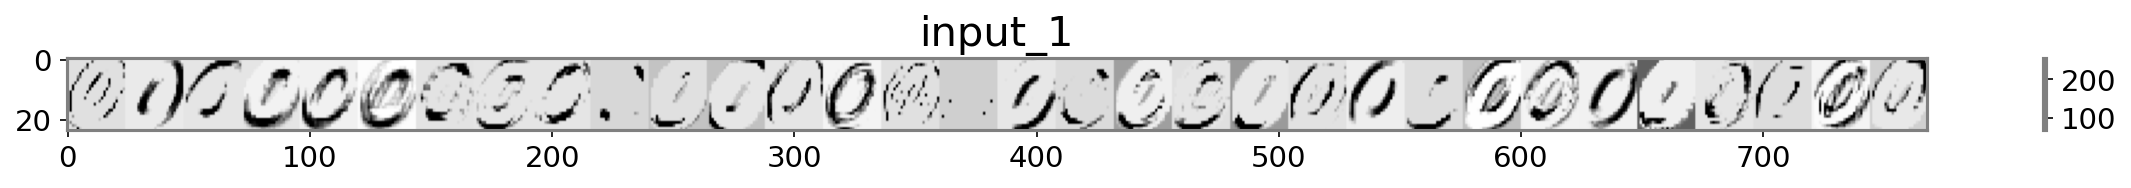

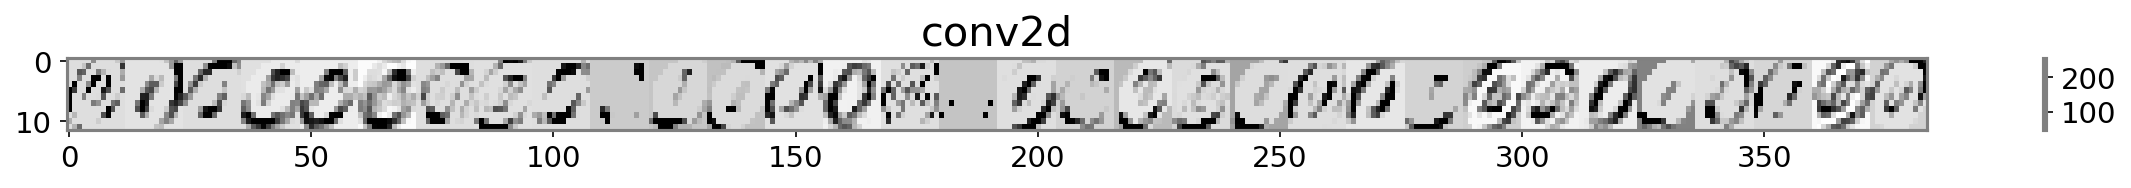

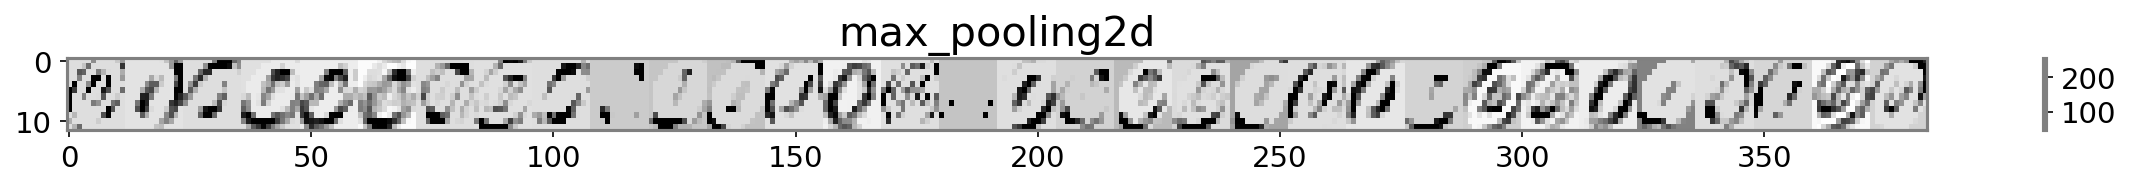

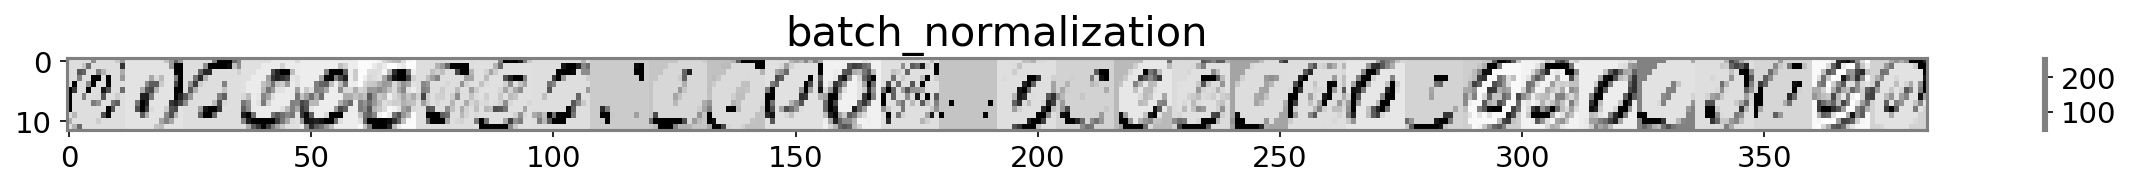

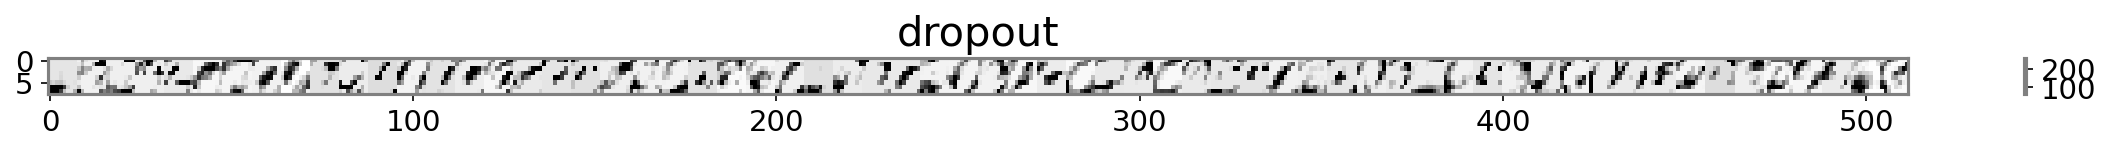

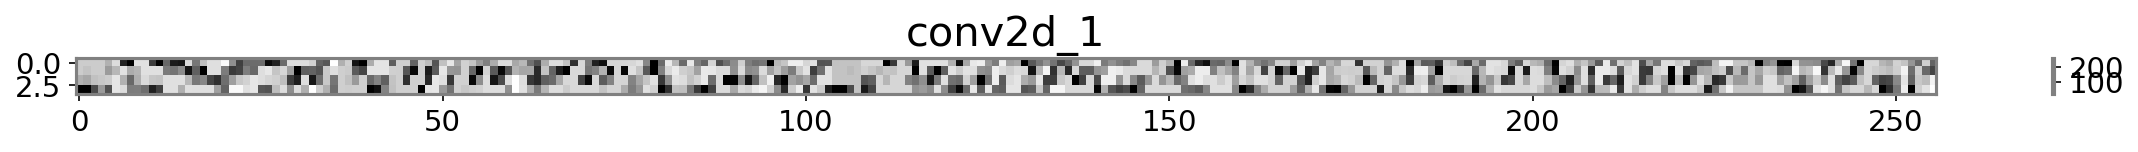

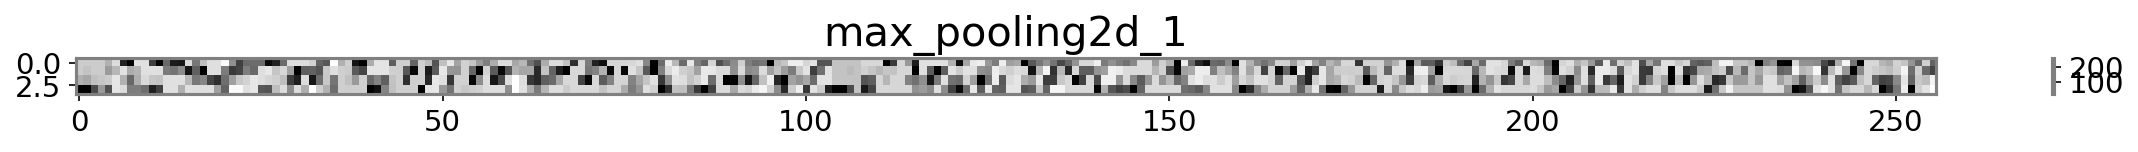

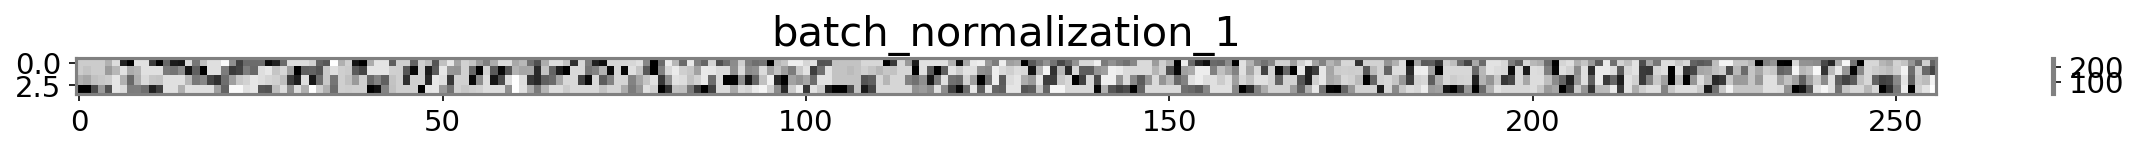

In [22]:
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    print(layer_name)
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size = feature_map.shape[1]  # feature map shape (1, size, size, n_features)

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        # Postprocess the feature to be visually palatable
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype("uint8")
            # Tile each filter into a horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x

        # Display the grid
        scale = 20.0 / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect="auto", cmap="Greys")
        plt.colorbar()

plt.show()


##### We now have the feature map outputs at each layer. We can see from the outputted feature maps that some of the filters focused more on edges and outlines, while others on the overall shape and blobs.

## 4. The Visualization of Augmented Data

In [23]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.10,
)


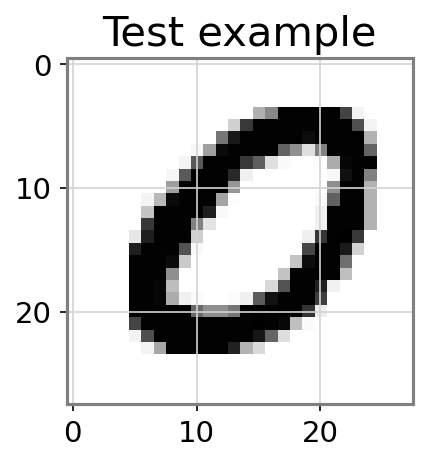

In [24]:
temp_example_X = X_train[12].reshape(-1, 28, 28, 1)
plt.figure(figsize=(3, 3))
plt.title("Test example")
plt.imshow(temp_example_X.squeeze(), cmap="Greys")


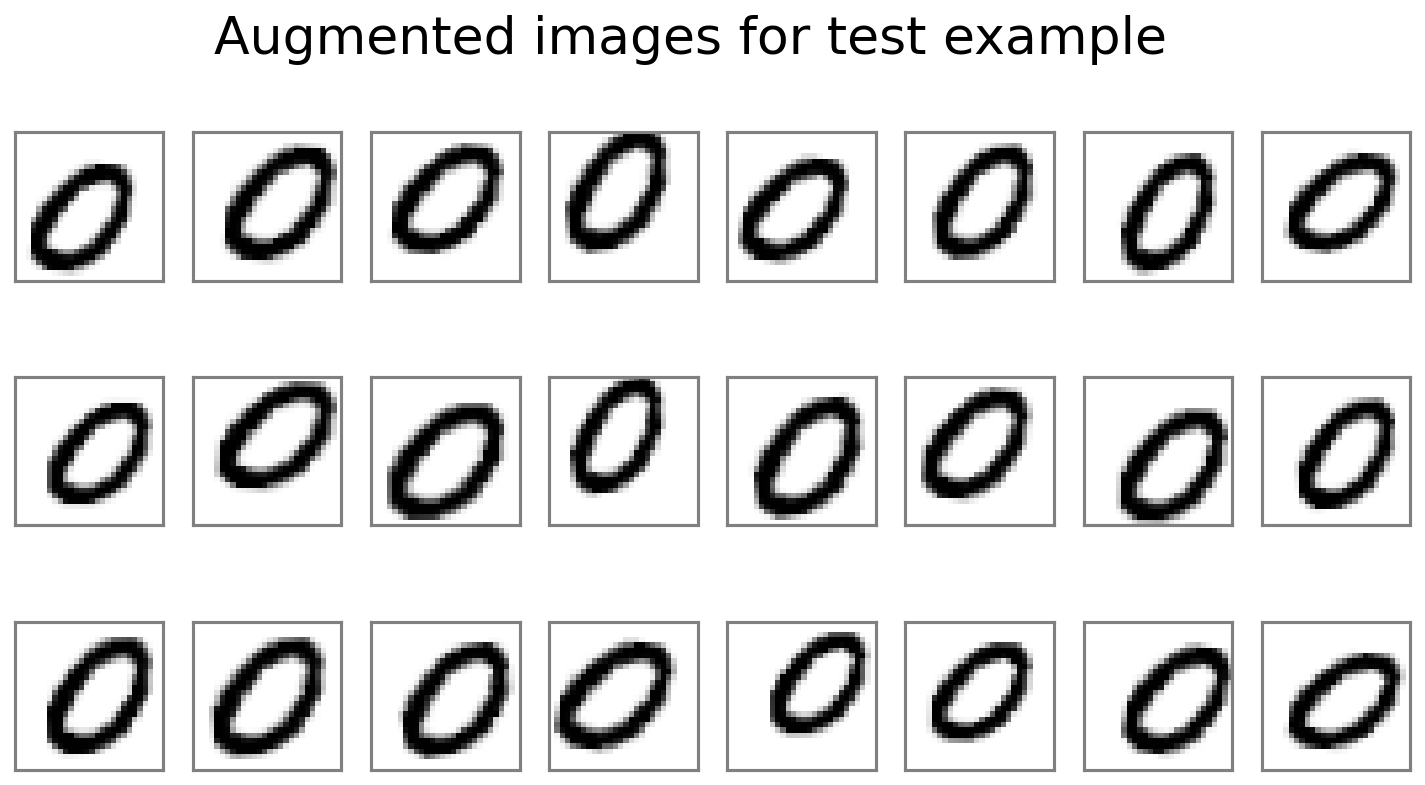

In [25]:
fig, axes = plt.subplots(3, 8, figsize=(12, 6))
fig.suptitle("Augmented images for test example")
for i in range(3):
    for j in range(8):
        augmented_example_X = datagen.flow(temp_example_X, batch_size=1).next()
        axes[i, j].imshow(augmented_example_X.squeeze(), cmap="Greys")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])


### 4.2 Validation results on augmented data

In [26]:
model2 = tf.keras.models.load_model(
    "../models/augmented_best_model.h5",
    custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m},
)


In [27]:
# we use argmax to get the index of the max value in each row
y_val_pred = np.argmax(model2.predict(X_val), axis=1)
print("y_val_pred", y_val_pred)
y_val_true = np.argmax(y_val, axis=1)
print("y_val_true", y_val_true)


132/132 [==============================] - 0s 3ms/step
y_val_pred [8 1 9 ... 7 7 5]
y_val_true [8 1 9 ... 7 7 5]


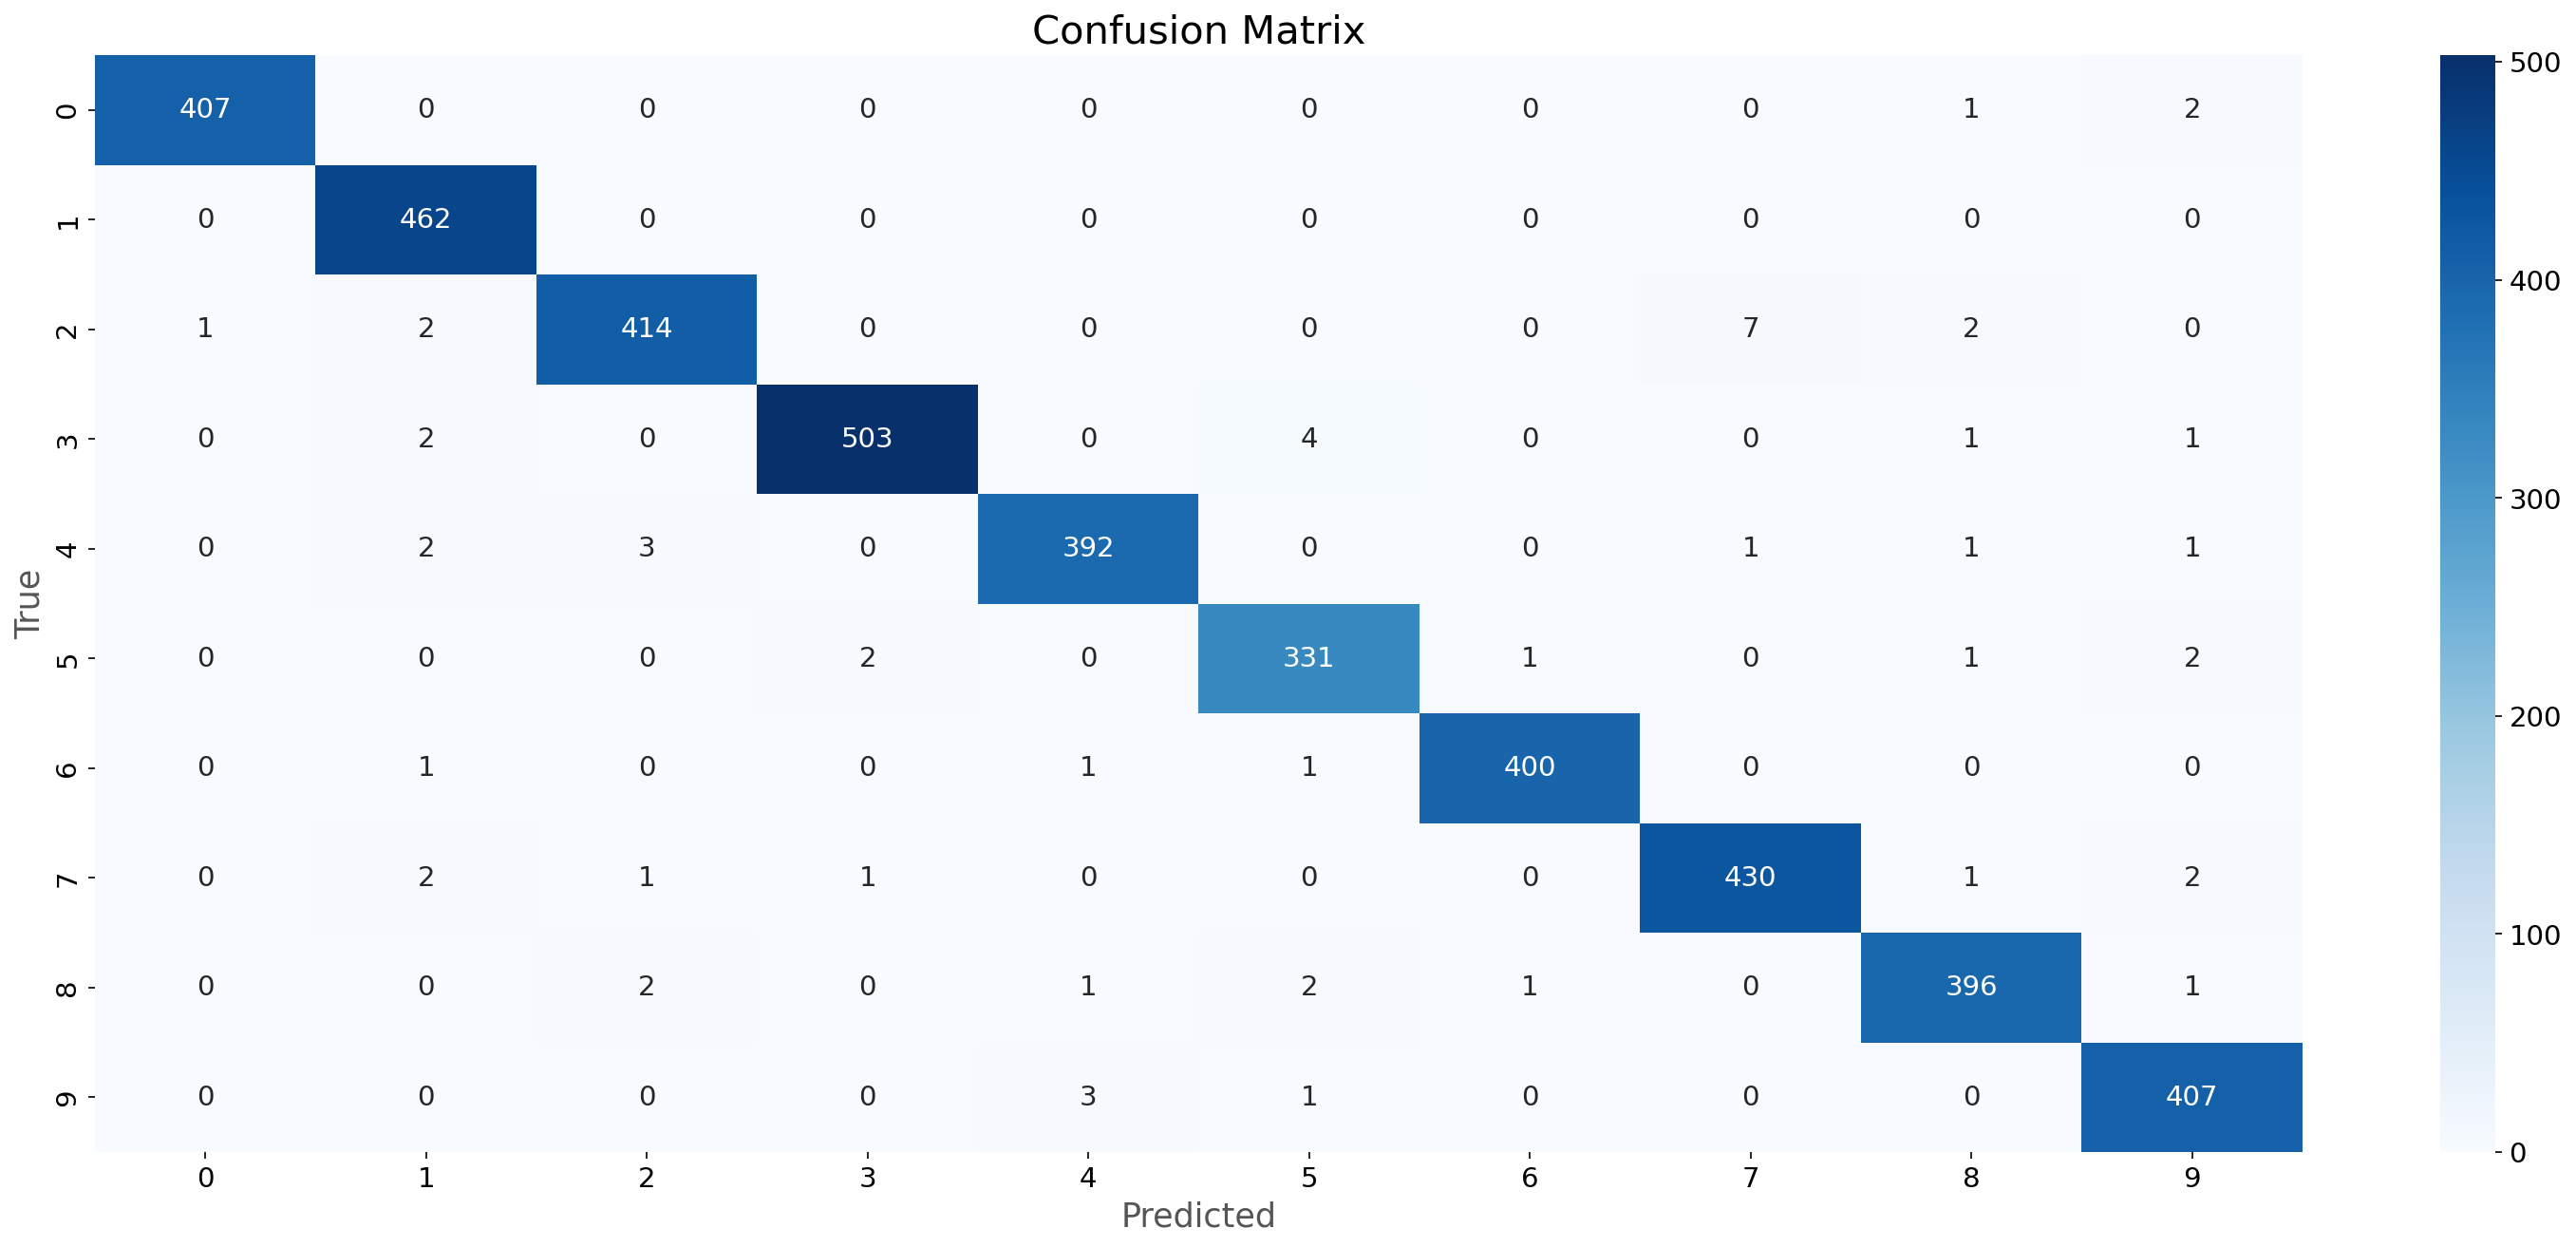

In [28]:
cm = confusion_matrix(y_val_pred, y_val_true)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [29]:
accuracy_score(y_val_true, y_val_pred)


0.9861904761904762

## 5. Hyper-parameter Result

### 5.1 RandomSearch Result

In [32]:
top_model_random = tf.keras.models.load_model(
    "../models/random_search/top_model_random.h5",
    custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m},
)


In [34]:
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(top_model_random.predict(X_val), axis=1)
accuracy_score(y_val_true, y_val_pred)


132/132 [==============================] - 2s 17ms/step


0.985

### 5.2 HyperBand Result